In [1]:
%cd drive/My\ Drive/colab/dncnn

/content/drive/My Drive/colab/dncnn


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU


class DnCNN(Model):
    def __init__(self, depth=17):
        super(DnCNN, self).__init__()
        self.conv1 = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=he_uniform())
        self.conv_bn_relu = [ConvBNReLU() for i in range(depth - 2)]
        self.conv_final = Conv2D(1, 3, padding='same', kernel_initializer=he_uniform())

    def call(self, x):
        x = self.conv1(x)
        for cbr in self.conv_bn_relu:
            x = cbr(x)
        return self.conv_final(x)


class ConvBNReLU(Model):
    def __init__(self):
        super(ConvBNReLU, self).__init__()
        self.conv = Conv2D(64, 3, padding='same', kernel_initializer=he_uniform())
        self.bn = BatchNormalization()
        self.relu = ReLU()

    def call(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.relu(x)


In [ ]:
class DnCNNRN(Model):
    def __init__(self, depth=8):
        super(DnCNNRN, self).__init__()
        
        self.conv1 = Conv2D(64, 3, padding='same', kernel_initializer=he_uniform())
        #self.bn1 = BatchNormalization()
        self.relu1 = ReLU()

        self.rn_layers = [BasicBlock() for i in range(depth)]

        self.conv_final = Conv2D(1, 3, padding='same', kernel_initializer=he_uniform())

    def call(self, x):
        x = self.conv1(x)
        #x = self.bn1(x)
        x = self.relu1(x)
        for layer in self.rn_layers:
            x = layer(x)
        return self.conv_final(x)


class BasicBlock(Model):
    def __init__(self):
        super(BasicBlock, self).__init__()
        self.conv1 = Conv2D(64, 3, padding='same', kernel_initializer=he_uniform())
        self.bn1 = BatchNormalization()
        self.relu = ReLU()
        self.conv2 = Conv2D(64, 3, padding='same', kernel_initializer=he_uniform())
        self.bn2 = BatchNormalization()

    def call(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity

        out = self.relu(out)

        return out

In [ ]:
import random
import numpy as np
import datetime

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
#from dncnn import DnCNN
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

batch_size = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
def process_path(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img


def gaussian_noise_layer(dim):
    std = 25#random.randint(0, 55)
    noise = tf.random.normal(shape=[dim, dim, 1], mean=0.0, stddev=std, dtype=tf.float32)/255.0
    return noise

scales = [1, 0.9, 0.8, 0.7]
def augment(image):
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels=1)
    h, w = float(tf.shape(image)[0]), float(tf.shape(image)[1])
    s = random.choice(scales)
    image = tf.image.resize(image, [int(h*s),int(w*s)])/250
    #image = tf.image.resize(image, [180,180])/250 #todo: check if it makes it better
    image = tf.image.random_crop(image, size=[40,40 , 1])
    image = tf.image.random_flip_left_right(image)
    for i in range(np.random.randint(4)):
      image = tf.image.rot90(image)
    noise = gaussian_noise_layer(40)
    image = tf.image.convert_image_dtype(image, tf.float32)
    noisy_image = tf.clip_by_value(image + noise, 0, 1)

    return noisy_image, noise, image

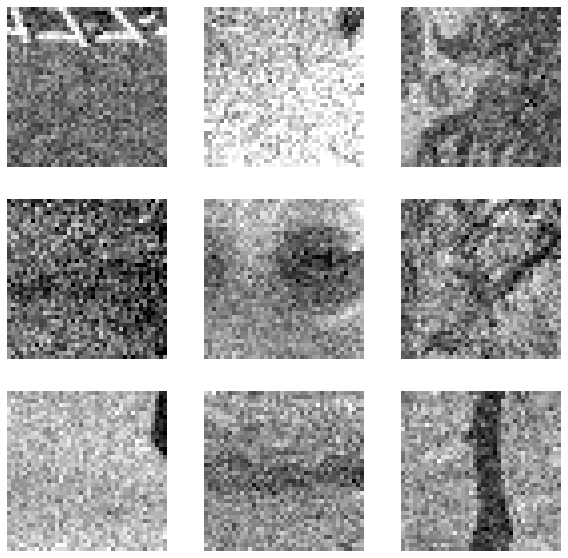

In [ ]:
@tf.function
def train_step(images, targets, true):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(targets, predictions)
        metric = tf.image.psnr(images-predictions, true,  max_val=1.0)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_metric(metric)


data_dir = 'data/train/*.jpg'

train_ds = tf.data.Dataset.list_files(data_dir)


# train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)


def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = configure_for_performance(train_ds)

image_batch, target_batch, _ = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().squeeze(), cmap='gray')
    plt.axis("off")

In [ ]:
@tf.function
def test_step(images, labels, true):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)
  t_metric = tf.image.psnr(images-predictions, true,  max_val=1.0)

  test_loss(t_loss)
  test_metric(t_metric)
  

def augment_test(image):
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize_with_crop_or_pad(image, 180, 180)
    image = tf.image.convert_image_dtype(image, tf.float32)
    noise = gaussian_noise_layer(180)
    noisy_image = tf.clip_by_value(image + noise, 0, 1)

    return noisy_image, noise, image

def configure_for_test(ds):
    ds = ds.cache()
    ds = ds.map(augment_test, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [ ]:
test_dir = 'data/test/*.jpg'

test_ds = tf.data.Dataset.list_files(test_dir)
test_ds = configure_for_test(test_ds)

In [ ]:
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

In [ ]:
model = DnCNN()

loss_object = MeanSquaredError()

#optimizer = Adam()
optimizer = tfa.optimizers.AdamW(weight_decay=0.0001,learning_rate=0.001)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_metric = tf.keras.metrics.Mean(name='train_metric')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_metric = tf.keras.metrics.Mean(name='test_metric')
EPOCHS = 500

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/'+current_time+'/vgg_aug_wd_scales'
summary_writer = tf.summary.create_file_writer(log_dir)

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_metric.reset_states()
    test_loss.reset_states()
    test_metric.reset_states()
    for images, targets, true in train_ds:
        train_step(images, targets, true)
    
    for test_images, test_labels, test_true in test_ds:
      test_step(test_images, test_labels, test_true)

    with summary_writer.as_default():
      tf.summary.scalar('train_loss', train_loss.result(), step=epoch)
      tf.summary.scalar('train_psnr', train_metric.result(), step=epoch)
      tf.summary.scalar('test_loss', test_loss.result(), step=epoch)
      tf.summary.scalar('test_psnr', test_metric.result(), step=epoch)

In [ ]:
model.save_weights('weights/vgg')

In [ ]:
model = DnCNN()
model.load_weights('weights/vgg')

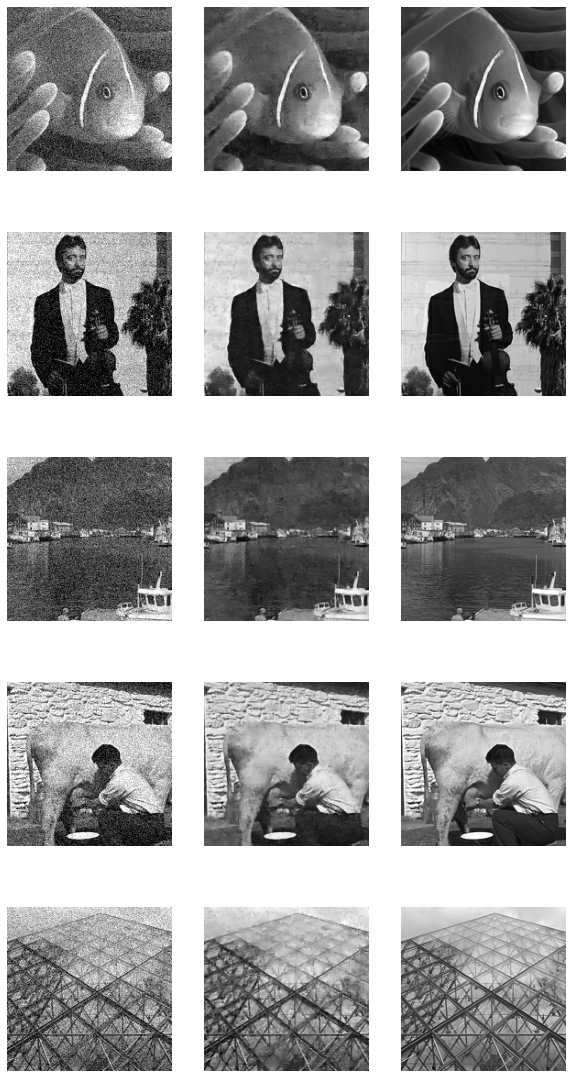

In [ ]:
image_batch, target_batch, true_batch = next(iter(test_ds))
predictions = model(image_batch, training=False)


columns = 3
rows = 5
fig = plt.figure(figsize=(10, 20))
for i in range(rows):
    fig.add_subplot(rows,columns,1+(i*columns))
    plt.imshow(image_batch[i].numpy().squeeze(), cmap='gray')
    plt.axis("off")
    fig.add_subplot(rows,columns,2+(i*columns))
    plt.imshow((image_batch[i]-predictions[i]).numpy().squeeze(), cmap='gray')
    plt.axis("off")
    fig.add_subplot(rows,columns,3+(i*columns))
    plt.imshow(true_batch[i].numpy().squeeze(), cmap='gray')
    plt.axis("off")

plt.show()


In [ ]:
model.save('saved_model/vgg') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/vgg/assets


In [ ]:



tflite_model_quant_file = tflite_models_dir/"vgg.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

679968

In [ ]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

In [ ]:
test_image = np.expand_dims(image_batch[0], axis=0).astype(np.float32)
input_index = interpreter_quant.get_input_details()[0]["index"]
output_index = interpreter_quant.get_output_details()[0]["index"]

interpreter_quant.set_tensor(input_index, test_image)
interpreter_quant.invoke()
predictions = interpreter_quant.get_tensor(output_index)

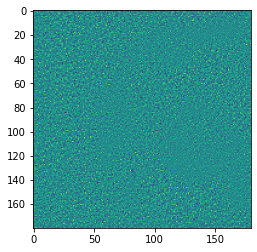

In [ ]:
plt.imshow(predictions[0].squeeze())

In [ ]:
def augment_12(image):
    image = tf.io.read_file(image)
    image = tf.image.decode_png(image,1)
    #image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize_with_crop_or_pad(image, 180, 180)
    image = tf.image.convert_image_dtype(image, tf.float32)
    noise = gaussian_noise_layer(180)

    return image + noise, noise, image

def configure_for_12(ds):
    ds = ds.cache()
    ds = ds.map(augment_12, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(12)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

dir_12 = 'data/12/*.png'

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_metric = tf.keras.metrics.Mean(name='test_metric')
test_loss.reset_states()
test_metric.reset_states()
ds_12 = tf.data.Dataset.list_files(dir_12)
ds_12 = configure_for_12(ds_12)


for test_images, test_labels, test_true in ds_12:
    test_step(test_images, test_labels, test_true)
print(test_loss.result())
print(test_metric.result())

tf.Tensor(0.0017509445, shape=(), dtype=float32)
tf.Tensor(27.742498, shape=(), dtype=float32)


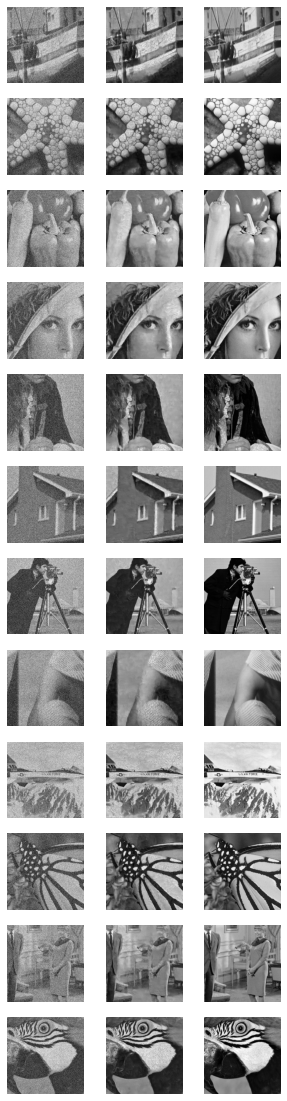

In [ ]:
image_batch, target_batch, true_batch = next(iter(ds_12))
predictions = model(image_batch, training=False)


columns = 3
rows = 12
fig = plt.figure(figsize=(5, 20))
for i in range(rows):
    fig.add_subplot(rows,columns,1+(i*columns))
    plt.imshow(image_batch[i].numpy().squeeze(), cmap='gray')
    plt.axis("off")
    fig.add_subplot(rows,columns,2+(i*columns))
    plt.imshow((image_batch[i]-predictions[i]).numpy().squeeze(), cmap='gray')
    plt.axis("off")
    fig.add_subplot(rows,columns,3+(i*columns))
    plt.imshow(true_batch[i].numpy().squeeze(), cmap='gray')
    plt.axis("off")

plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('tmp/model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    # Get sample input data as a numpy array in a method of your choosing.
    yield [input]
converter.representative_dataset = representative_dataset_gen
tflite_quant_model = converter.convert()